In [ ]:
# Date: 20.3.2023
# Author: Antti Kiviaho
#
# Notebook for analysing and visualizing visium data after copy number variation, single cell mapping and clustering
# analyses. This is the main results notebook

## Packages and data download

In [ ]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids
import matplotlib as mpl
from sklearn.decomposition import NMF

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")



adata_slides = load_from_pickle('./data/clustered_visium_data.pickle')
samples = get_sample_ids()

# Change the run_name variable to select the appropriate iteration
run_name = '20230908'




In [ ]:
# Download data and format cell2location mapping results into obs columns in both aggregated adata and individual slides
adata_vis = sc.read_h5ad('./c2l-results/visium_adata_with_c2l_mapping_'+run_name+'.h5ad')

adata_vis.obs.joint_leiden_clusters = adata_vis.obs.sample_id.astype(str) + '_' + adata_vis.obs.joint_leiden_clusters.astype(str)
adata_vis.obs['joint_leiden_clusters'] = pd.Categorical(adata_vis.obs['joint_leiden_clusters'])

# Copy obsm (cell2location results) to adata object obs
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# Copy obsm (cell2location results) to individual slides
for sample in samples:
    vis_subset = adata_vis[adata_vis.obs['sample_id']==sample]
    
    if (vis_subset.obs_names == adata_slides[sample].obs_names).all():
        adata_slides[sample].obsm = vis_subset.obsm.copy()
        
        # add 5% quantile, representing confident cell abundance, 'at least this amount is present',
        # to adata.obs with nice names for plotting
        adata_slides[sample].uns['mod'] = vis_subset.uns['mod'].copy()
        adata_slides[sample].obs[adata_slides[sample].uns['mod']['factor_names']] = adata_slides[sample].obsm['q05_cell_abundance_w_sf']


## Looking at macrophage polarization-related gene set (Ketola) 

In [ ]:
PCa_samples = get_sample_ids('PCa')

In [ ]:
slide = adata_slides[PCa_samples[17]].copy()

In [ ]:
for sample in PCa_samples:
    slide = adata_slides[sample]
    M1_signature = ['CD86','NOS2','MARCO','HLA-DRB1','HLA-DQB1','HLA-DRA','ITGAX','TLR2','TLR4']
    [g for g in M1_signature if g in slide.var.index]
    sc.tl.score_genes(slide,M1_signature,score_name='M1_signature')
    sc.pl.spatial(slide, cmap='magma',color='M1_signature',
                        size=1.3,alpha_img=0.8)

In [ ]:

samples = get_sample_ids()
cd3_genes = ['CD3D','CD3E','CD247']
n_rows = 1  # Set the number of rows and columns for the subplots
n_cols = len(cd3_genes)

for s in samples:
    adata = adata_vis[adata_vis.obs['sample_id'] == s]

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 3))  # Create the figure with subplots
    fig.suptitle(s) 

    for i, g in enumerate(cd3_genes):
        if g in list(adata.var.index):
            gene_expr = adata[:,g].layers['counts'].toarray().ravel()
            gene_expr = gene_expr[gene_expr != 0]  # Exclude 0 values
            bins = np.arange(1, 11) - 0.5  # Define bins to center histogram bars on integer values
            axs[i].hist(gene_expr, bins=bins)
            axs[i].set_xticks(np.arange(1, 11))  # Set x-axis ticks from 1 to 10
            axs[i].set_ylabel('Frequency')

    plt.show()


## Looking at T-cell receptor subunit coverage across the slides

In [ ]:
samples = get_sample_ids()
cd3_genes = ['CD3D','CD3E','CD247']
n_rows = 1  # Set the number of rows and columns for the subplots
n_cols = len(cd3_genes)

for s in samples:
    adata = adata_vis[adata_vis.obs['sample_id'] == s]

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 3))  # Create the figure with subplots
    fig.suptitle(s) 

    for i, g in enumerate(cd3_genes):
        if g in list(adata.var.index):
            gene_expr = adata[:,g].layers['counts'].toarray().ravel()
            gene_expr = gene_expr[gene_expr != 0]  # Exclude 0 values
            bins = np.arange(1, 11) - 0.5  # Define bins to center histogram bars on integer values
            axs[i].hist(gene_expr, bins=bins)
            axs[i].set_xticks(np.arange(1, 11))  # Set x-axis ticks from 1 to 10
            axs[i].set_ylabel('Frequency')

    plt.show()


In [ ]:
# This code will create a 5 by 5 inches axis for each plot, 
# save them in plots/c2l_mapping_results_20230511/ with a 
# sample-specific filename, and set the dpi to 300.
cd3_genes = ['CD3D','CD3E','CD247']
#samples = [s for s in samples if 'CRPC' in s]
import os
for sample in samples:
    slide = adata_slides[sample].copy()
    slide.obs['CD3_sum'] = np.sum(slide[:,cd3_genes].layers['counts'].todense(),axis=1).flatten().tolist()[0]

    # import matplotlib library
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_pdf import PdfPages

    # set figure axis size and dpi
    fig, ax = plt.subplots(figsize=(3, 3), dpi=100)

    # create spatial plot
    sc.pl.spatial(slide, cmap='viridis',
            # show first 8 cell types
            color='CD3_sum',size=1.3,alpha_img=0.8,
            vmin=0, vmax=6, ax=ax, show=False, title=sample)

    # create filename with sample name
    filename = 'plots/c2l_mapping_results_20230721/cd3_expression/' + sample + '_spatial_cd3_sum_plot.pdf'

    # create output folder if it doesn't exist
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))

    # save plot to pdf with filename
    with PdfPages(filename) as pdf:
        pdf.savefig(fig)


## Visium mapping plots

In [ ]:
# Plots and saves top n_types with highest prevelance on visium slides
n_types = 12

for sample in samples:
    slide = adata_slides[sample]
    # Subset to only plot the cell types with highest mean prevalence
    cell_types = slide.obs.iloc[:,16:].mean(axis=0).sort_values(ascending=False)[:n_types]

    # plot in spatial coordinates
    with mpl.rc_context({'axes.facecolor':  'black',
                        'figure.figsize': [4.5, 5]}):

        sc.pl.spatial(slide, cmap='magma',
                    # show first 8 cell types
                    color=cell_types.index,
                    ncols=4, size=1.3,alpha_img=0.8,
                    # limit color scale at 99.2% quantile of cell abundance
                    vmin=0, vmax='p99.2', show=False
                    )
        plt.savefig('./plots/c2l_mapping_results_'+run_name+'/'+sample+'_c2l_mapping_top12_abundant.png',dpi=200)
        plt.clf()

In [ ]:
## Side by side violin plots of abundant cell types + spatial 

plt.rcParams.update({'axes.titlesize': 'small'})

n_types = 6
obs_name = 'joint_leiden_clusters'

for s in samples:

    slide = adata_slides[s].copy()

    # Subset to only plot the cell types with highest mean prevalence
    cell_counts = slide.obs[adata_vis.uns['mod']['factor_names']]
    cell_type_pcts = cell_counts.div(cell_counts.sum(axis=1),axis=0)*100
    cell_types_to_plot = cell_type_pcts.mean(axis=0).sort_values(ascending=False)[:n_types].index


    # Iterate over the columns of df2
    for column in cell_type_pcts.columns:
        # Check if the column exists in df1
        if column in slide.obs.columns:
            # Replace the column in df1 with the corresponding column from df2
            slide.obs[column] = cell_type_pcts[column]


    fig = plt.figure(figsize=(16,16))

    gs = fig.add_gridspec(6,3)
    ax6 = fig.add_subplot(gs[:, 1:3])

    # Plot the data in the left column subplots
    for i in range(6):

        ax_plotting = fig.add_subplot(gs[i,0])

        sc.pl.violin(slide,groupby=obs_name,keys=cell_types_to_plot[i],jitter=False,rotation=45,inner='box',
                    ax=ax_plotting,show=False)
        
        ax_plotting.yaxis.label.set_size(12)
        ax_plotting.yaxis.label.set_rotation(75)

        if i < 5:  # only remove x-labels for the top 5 subplots on the left
            ax_plotting.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 

    sc.pl.spatial(adata_slides[s],color='joint_leiden_clusters',size=1.3,ax=ax6)

    fig.savefig('./plots/c2l_mapping_results_'+run_name+'/'+s+'_cell_type_prevalences_per_cluster.png')
    plt.clf()



## Secondary analysis of the cell type mapping numbers

In [ ]:
# Save the cell mapping data into an array
""" 
cell_types = list(adata_vis.uns['mod']['factor_names'])
ctype_dat = np.array(adata_vis.obs[cell_types].copy())
ctype_dat_obs = adata_vis.obs.drop(columns=cell_types).copy()
ctype_dat_var = pd.DataFrame(index=cell_types)
cell_mapping_dat = ad.AnnData(X=ctype_dat,obs=ctype_dat_obs,var=ctype_dat_var)

cell_mapping_dat.write('c2l_mapping_as_anndata_'+run_name+'.h5ad')
 """

In [1]:
from sklearn.preprocessing import LabelEncoder
import random
from xgboost import XGBClassifier


import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids
import matplotlib as mpl
from sklearn.decomposition import NMF

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


adata_slides = load_from_pickle('./data/clustered_visium_data.pickle')
samples = get_sample_ids()

# Change the run_name variable to select the appropriate iteration
run_name = '20230908'

cell_mapping_dat = sc.read_h5ad('c2l_mapping_as_anndata_'+run_name+'.h5ad')
cell_types = list(cell_mapping_dat.var_names)


In [2]:
# Summarize the data

X = cell_mapping_dat.X.copy()
obs_data = cell_mapping_dat.obs.copy().reset_index(drop=True)

sum_categories = obs_data['joint_leiden_clusters'].value_counts().index
N_obs = len(sum_categories)
N_var = X.shape[1]
X_summed = np.empty((N_obs, N_var))


for i,cl in enumerate(sum_categories):
    
    idxs = obs_data[obs_data['joint_leiden_clusters'] == cl].index
    X_summed[i] = X[idxs].mean(axis=0)

# Create a new anndata object with summarized data
summarized_data = ad.AnnData(X=X_summed,obs=pd.DataFrame(index=sum_categories),var=cell_mapping_dat.var.copy())

In [3]:
# Run NMF to find 'tissue regions'
nmf_res_dict = {}
nmf_cell_weights_dict = {}
adata = cell_mapping_dat.copy()

# Set the range of components
component_range = range(5, 13)

# Perform NMF
for n_components in component_range:
    nmf = NMF(n_components=n_components)
    W = nmf.fit_transform(adata.X)
    H = nmf.components_

    nmf_res = pd.DataFrame(H.T,
                        index=adata.var_names,
                        columns=list(np.arange(0,n_components)+1),)

    nmf_res_dict[n_components] = nmf_res
    nmf_cell_weights_dict[n_components] = W

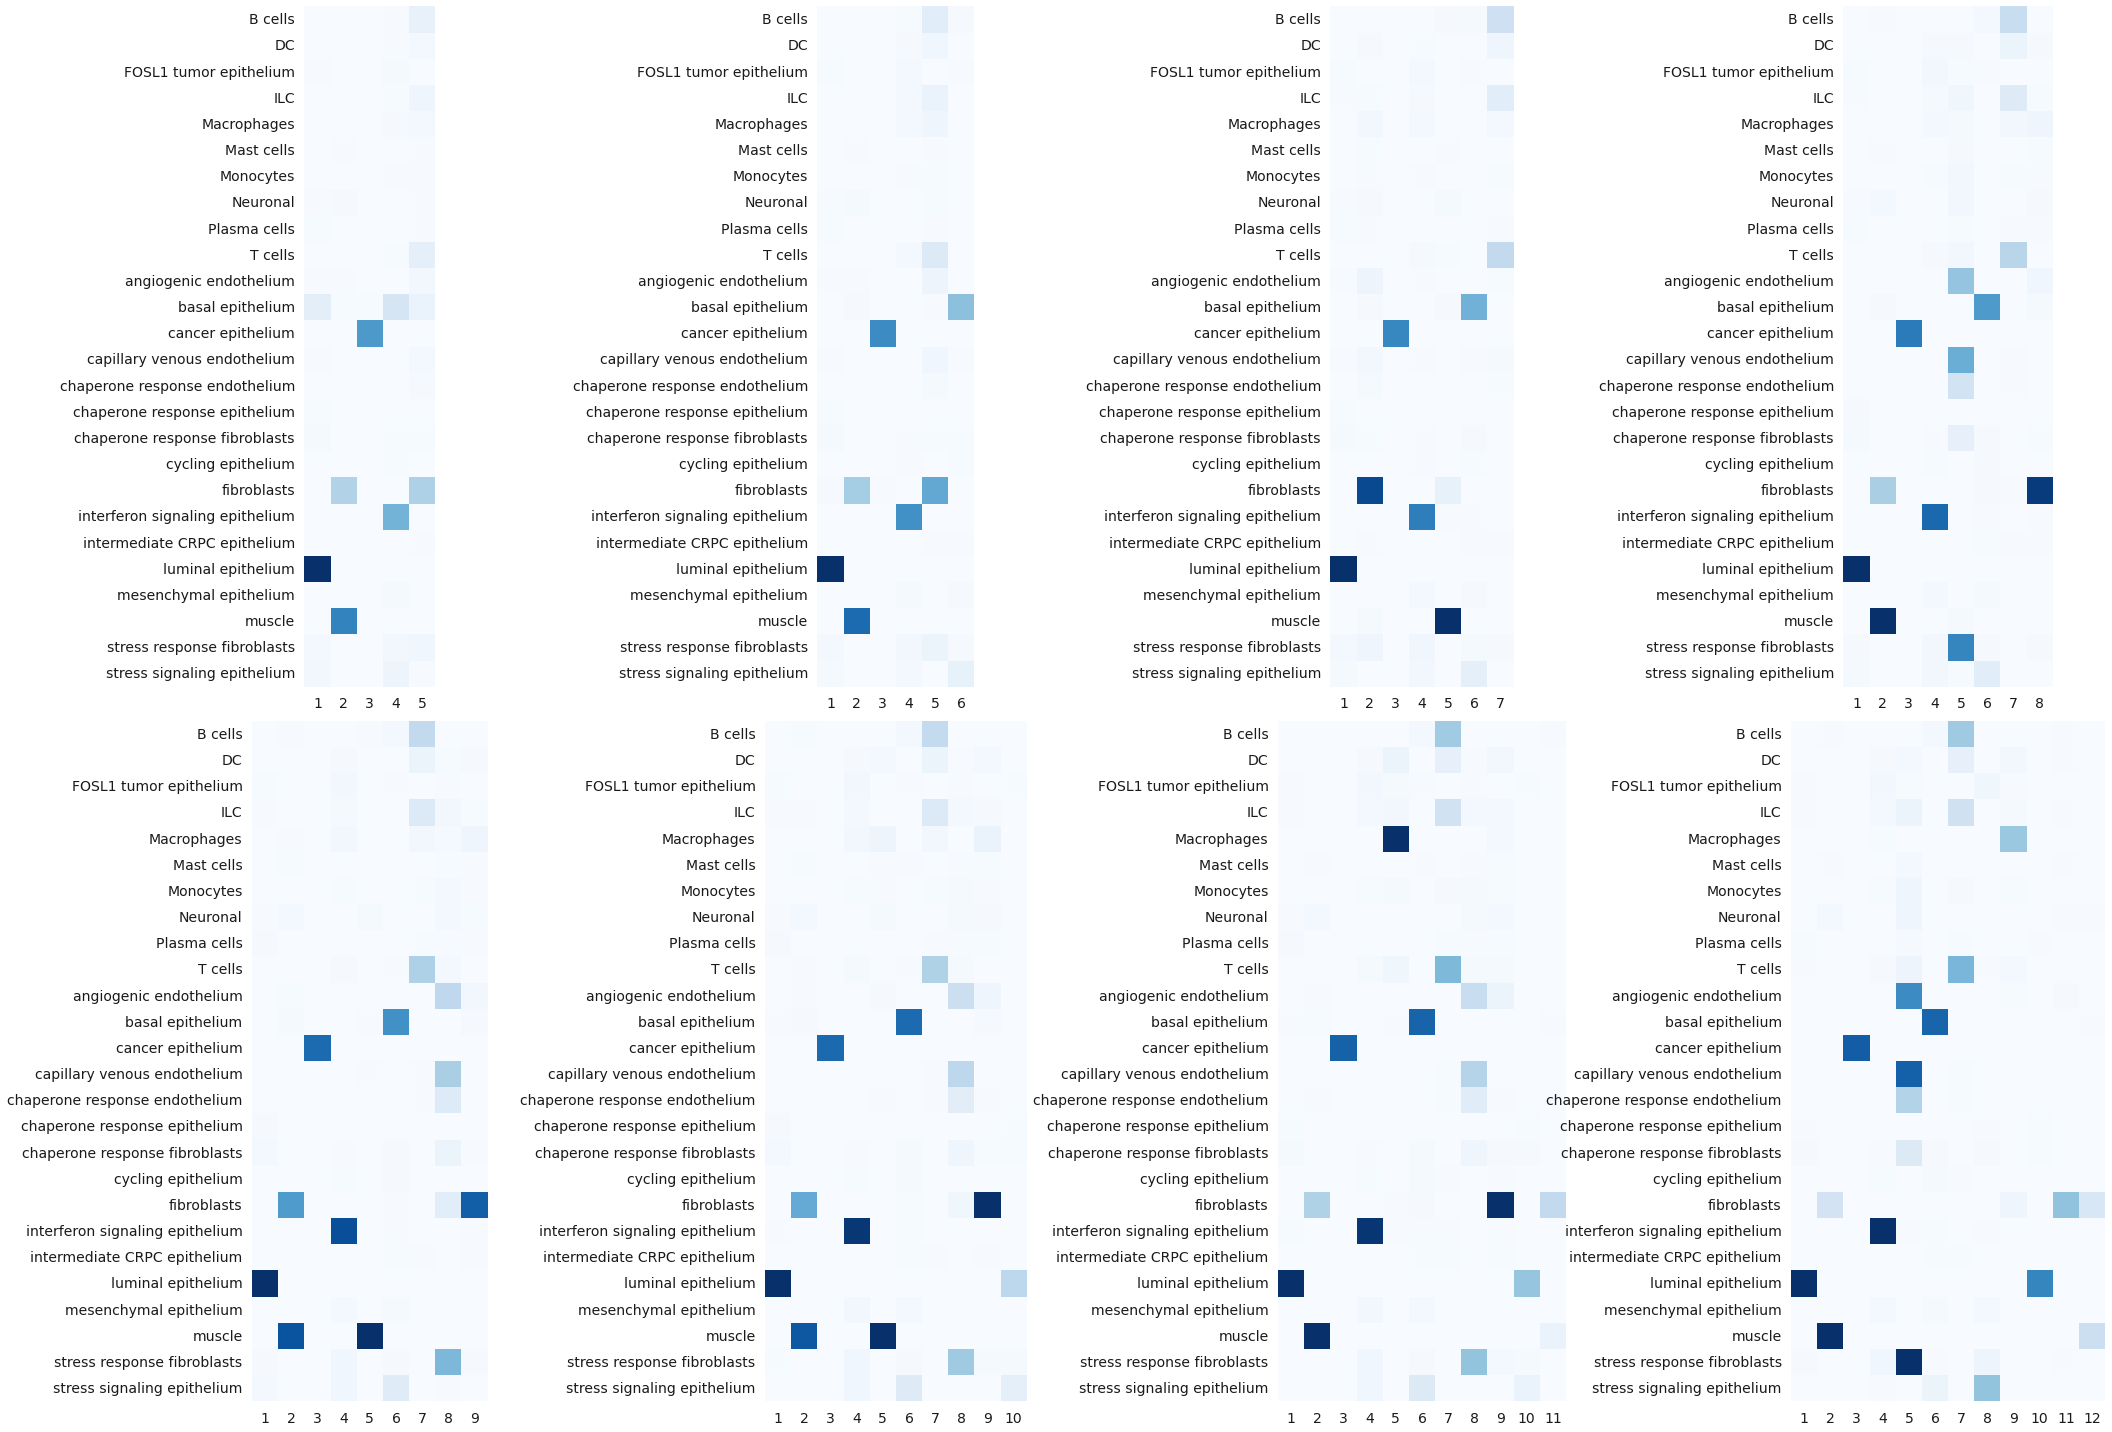

In [4]:
# Plot the nmf results on two rows
# Create subplots with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(30, 20))

for i, n_components in enumerate(component_range):

    # Drop the redundant cell types prior to plotting
    nmf_res_for_plotting = nmf_res_dict[n_components].copy()
    #nmf_res_for_plotting = nmf_res_for_plotting.loc[~(nmf_res_for_plotting.max(axis=1) < nmf_res_for_plotting.stack().quantile(0.9))]

    # Determine the position of the subplot on the grid
    row = i // 4
    col = i % 4
    
    # Plot the heatmap on the corresponding subplot
    sns.heatmap(nmf_res_for_plotting, cmap='Blues', square=True, ax=axs[row, col], vmax=100,cbar=False)

plt.tight_layout()
plt.show()


In [5]:
tissue_region_names = {1:'Luminal epithelium', 2:'Muscle', 3:'Cancer epithelium', 4:'Interferon signaling epithelium',
                       5:'Endothelium', 6:'Basal epithelium', 7:'Immune', 8:'Fibroblast'}

# Sorting out the colors for tissue regions (Set2 palette)
sorted_region_names = np.sort(list(tissue_region_names.values())).tolist()
tissue_region_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']
region_colors_dict = dict(zip(sorted_region_names,tissue_region_colors))

# Number 8 is the best fit
tissue_regions = nmf_res_dict[8].copy().rename(columns=tissue_region_names)

In [6]:

nmf_obs_weights = pd.DataFrame(nmf_cell_weights_dict[8],columns=list(tissue_region_names.values()),index=cell_mapping_dat.obs_names)
nmf_obs_annot = nmf_obs_weights.idxmax(axis=1)

obs_data.index = cell_mapping_dat.obs_names
obs_data['nmf_weight_based_regions'] = nmf_obs_annot
nmf_obs_annot.value_counts()


Muscle                             27079
Cancer epithelium                  24613
Basal epithelium                   13319
Luminal epithelium                 12800
Fibroblast                         12072
Interferon signaling epithelium     5937
Immune                              4964
Endothelium                         1085
dtype: int64

In [138]:
samples = get_sample_ids()
for sample in samples:
    slide = adata_slides[sample]
    slide.obs['predicted_region'] = obs_data.loc[slide.obs_names]['nmf_weight_based_regions']

    # Get the colors considering some might be missing
    slide.uns['predicted_region_colors'] = [region_colors_dict[region] for region in np.sort(slide.obs['predicted_region'].unique()).tolist()]

    fig,ax_plotting = plt.subplots(1,2,figsize=(18,9))
    sc.pl.spatial(slide,color='predicted_region',size=1.3,ax=ax_plotting[0],show=False)
    sc.pl.spatial(slide,color='joint_leiden_clusters',size=1.3,ax=ax_plotting[1],show=False)
    plt.tight_layout()
    plt.savefig('./plots/c2l_mapping_results_'+run_name+'/'+sample+'_side_by_side_nmf_obs_weight_based_tissue_regions_spatial.pdf')
    plt.clf()
    

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<AxesSubplot: >

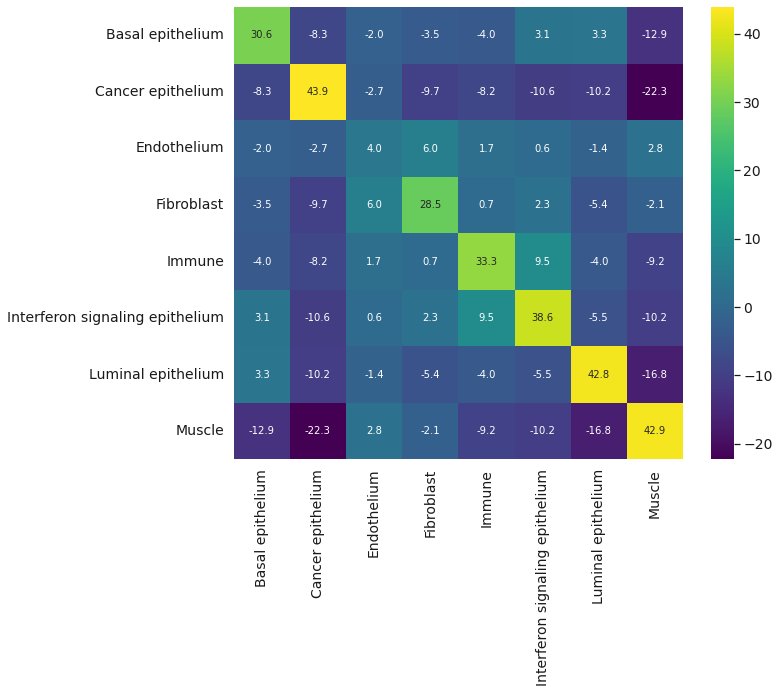

In [7]:
summary_mat = np.zeros((len(sorted_region_names),len(sorted_region_names)))
for sample in samples:
    slide = adata_slides[sample].copy()    
    slide.obs['predicted_region'] = obs_data.loc[slide.obs_names]['nmf_weight_based_regions'].astype('category')
    sq.gr.nhood_enrichment(slide, cluster_key='predicted_region',show_progress_bar=False)
    
    mat = slide.uns['predicted_region_nhood_enrichment']['zscore'].copy()
    mat = np.nan_to_num(mat)


    missing = [c for c in sorted_region_names if c not in list(slide.obs['predicted_region'].cat.categories)]

    for missing_type in missing:

        insert_idx = list(sorted_region_names).index(missing_type)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[1]),axis = 0)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[0]),axis = 1)

    summary_mat += mat

fig,ax = plt.subplots(figsize=(10,8))
df = pd.DataFrame(summary_mat,index=sorted_region_names,columns=sorted_region_names)/len(samples)
sns.heatmap(df,cmap='viridis',ax=ax,annot=True,fmt='.1f')

## Switch from mapping annotation to cluster-affected annotation

In [8]:
# 
top_proportion = []
cluster_to_region_dict = {}
for cl in obs_data['joint_leiden_clusters'].unique():
    val_counts = obs_data[obs_data['joint_leiden_clusters'] == cl]['nmf_weight_based_regions'].value_counts()
    top_proportion.append(val_counts[0]/val_counts.sum())
    cluster_to_region_dict[cl] = val_counts.index[0]

obs_data['clusters_as_regions'] = obs_data['joint_leiden_clusters'].map(cluster_to_region_dict)


<AxesSubplot: >

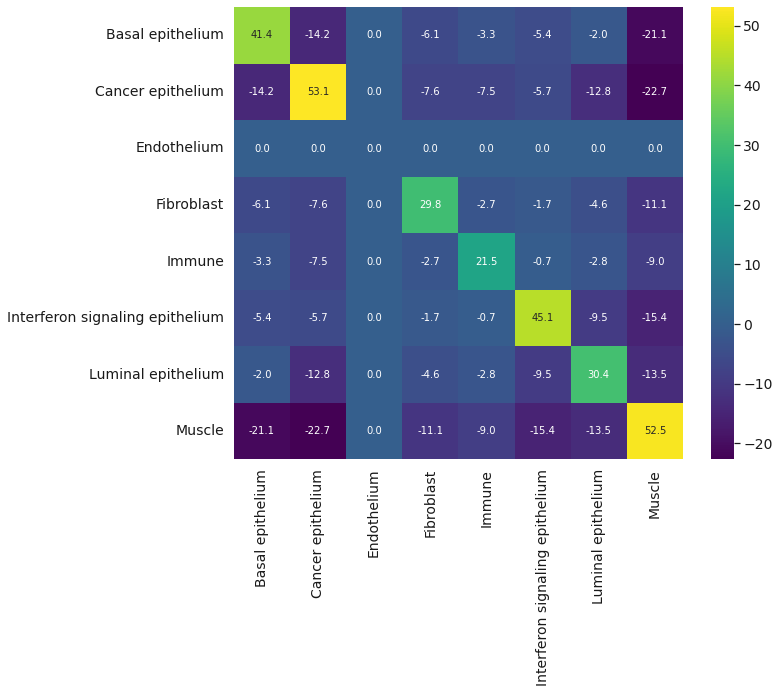

In [9]:
summary_mat = np.zeros((len(sorted_region_names),len(sorted_region_names)))
for sample in samples:
    slide = adata_slides[sample].copy()    

    slide.obs['clusters_as_regions'] = obs_data.loc[slide.obs_names]['clusters_as_regions'].astype('category')

    try:
        sq.gr.nhood_enrichment(slide, cluster_key='clusters_as_regions',show_progress_bar=False)

        mat = slide.uns['clusters_as_regions_nhood_enrichment']['zscore'].copy()
        mat = np.nan_to_num(mat)


        missing = [c for c in sorted_region_names if c not in list(slide.obs['clusters_as_regions'].cat.categories)]

        for missing_type in missing:

            insert_idx = list(sorted_region_names).index(missing_type)
            mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[1]),axis = 0)
            mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[0]),axis = 1)

        summary_mat += mat
    except:
        continue
fig,ax = plt.subplots(figsize=(10,8))
df = pd.DataFrame(summary_mat,index=sorted_region_names,columns=sorted_region_names)/len(samples)
sns.heatmap(df,cmap='viridis',ax=ax,annot=True,fmt='.1f')

In [10]:
samples = get_sample_ids()
for sample in samples:
    slide = adata_slides[sample].copy()
    slide.obs['clusters_as_regions'] = obs_data.loc[slide.obs_names]['clusters_as_regions']

    # Get the colors considering some might be missing
    slide.uns['clusters_as_regions_colors'] = [region_colors_dict[region] for region in np.sort(slide.obs['clusters_as_regions'].unique()).tolist()]

    fig,ax_plotting = plt.subplots(1,2,figsize=(18,9))
    sc.pl.spatial(slide,color='clusters_as_regions',size=1.3,ax=ax_plotting[0],show=False)
    sc.pl.spatial(slide,color='joint_leiden_clusters',size=1.3,ax=ax_plotting[1],show=False)
    plt.tight_layout()
    plt.savefig('./plots/c2l_mapping_results_'+run_name+'/'+sample+'_side_by_side_clusters_as_regions_spatial.pdf')
    plt.clf()
    

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

## Creating training data for xgboost

In [7]:
scale_factor = np.mean(cell_mapping_dat.X.ravel()) / tissue_regions.stack().mean()
scaled_tissue_regions = tissue_regions*scale_factor

# Creating training data 
cell_type_covariances = np.cov(cell_mapping_dat.X.T) *0.01
#cell_type_covariances = np.identity(26)

training_data = np.empty((0,len(cell_types)))
training_labels = []
n_samples = int(1e5)

for i,region in enumerate(scaled_tissue_regions.columns):

    cell_type_means = scaled_tissue_regions[region].copy()

    data = np.random.multivariate_normal(cell_type_means, cell_type_covariances, size=n_samples)

    # Set values below 0 to zero
    data[data < 0] = 0

    training_data = np.vstack([training_data,data])
    training_labels = training_labels + np.repeat(region,n_samples).tolist()

# Turn the labels to int and jointly shuffle data and labels
encoder = LabelEncoder()
training_labels_int = encoder.fit_transform(training_labels)

training_data,training_labels_int = unison_shuffled_copies(training_data,training_labels_int)


In [8]:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='multi:softmax')
# fit model
bst.fit(training_data, training_labels_int)

# make predictions
preds = bst.predict(cell_mapping_dat.X)
predicted_regions = encoder.inverse_transform(preds).tolist()

obs_df  = cell_mapping_dat.obs.copy()
obs_df['predicted_region'] = predicted_regions


## Plotting the predicted regions

In [11]:
obs_data.index = cell_mapping_dat.obs_names
samples = get_sample_ids()
for sample in samples:
    slide = adata_slides[sample]
    slide.obs['predicted_region'] = obs_df.loc[slide.obs_names]['predicted_region']

    # Get the colors considering some might be missing
    slide.uns['predicted_region_colors'] = [region_colors_dict[region] for region in np.sort(slide.obs['predicted_region'].unique()).tolist()]

    fig,ax_plotting = plt.subplots(1,2,figsize=(18,9))
    sc.pl.spatial(slide,color='predicted_region',size=1.3,ax=ax_plotting[0],show=False)
    sc.pl.spatial(slide,color='joint_leiden_clusters',size=1.3,ax=ax_plotting[1],show=False)
    plt.tight_layout()
    plt.savefig('./plots/c2l_mapping_results_'+run_name+'/'+sample+'_side_by_side_nmf_tissue_regions_spatial.pdf')
    plt.clf()
    

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

In [12]:
# For evaluating parameter choices
n_est_list = [2][::-1]
max_depth_list = [2]

for n_est in n_est_list:
    for max_depth in max_depth_list:
        bst = XGBClassifier(n_estimators=n_est, max_depth=max_depth, learning_rate=1, objective='multi:softmax', num_class=len(tissue_region_names))
        # fit model
        bst.fit(training_data, training_labels_int)

        # make predictions
        preds = bst.predict(cell_mapping_dat.X)
        predicted_regions = encoder.inverse_transform(preds).tolist()

        top_proportion = []  
        cell_mapping_dat.obs['predicted_region'] = predicted_regions
        obs_df  = cell_mapping_dat.obs.copy()

        for sp_cluster in obs_df['joint_leiden_clusters'].value_counts().index.tolist():
            val_counts = obs_df[obs_df['joint_leiden_clusters'] == sp_cluster]['predicted_region'].value_counts()
            top_proportion.append(val_counts[0] / val_counts.sum())
        top_proportion = pd.Series(top_proportion)
        
        print('Max depth: {}, N estimators: {}, mean agreement: {:.3f},'.format(max_depth,n_est,top_proportion.mean()))

Max depth: 2, N estimators: 2, mean agreement: 0.633,


## Evaluating mapping relation to clusters & looking at their co-occurrence

In [13]:
for sample in obs_df['sample_id'].value_counts().index.tolist():
    obs_df_subs = obs_df[obs_df['sample_id'] == sample].copy()
    for sp_cluster in obs_df_subs['joint_leiden_clusters'].unique():
                print(sp_cluster)
                print(obs_df_subs[obs_df_subs['joint_leiden_clusters'] == sp_cluster]['predicted_region'].value_counts())
                print('')

PC_06_04581_OIK_POST_0_4
Muscle                             511
Cancer epithelium                  170
Fibroblast                          25
Luminal epithelium                  16
Immune                              14
Endothelium                          8
Interferon signaling epithelium      1
Basal epithelium                     1
Name: predicted_region, dtype: int64

PC_06_04581_OIK_POST_0_5
Immune                             96
Muscle                             80
Luminal epithelium                 76
Interferon signaling epithelium    45
Fibroblast                         38
Cancer epithelium                  33
Endothelium                        20
Basal epithelium                    3
Name: predicted_region, dtype: int64

PC_06_04581_OIK_POST_0_2
Luminal epithelium                 384
Muscle                             288
Cancer epithelium                   72
Basal epithelium                    23
Interferon signaling epithelium      7
Fibroblast                           1

In [17]:
top_proportion = []
for cl in obs_df['joint_leiden_clusters'].cat.categories:
    obs_df_subs = obs_df[obs_df['joint_leiden_clusters'] == cl].copy()
    val_counts = obs_df_subs['predicted_region'].value_counts()
    top_proportion.append(val_counts.index[0])
    print(cl + ' top type is ' + val_counts.index[0] + ' at {:.2f} purity'.format(val_counts[0]/val_counts.sum()))

pd.Series(top_proportion).value_counts()

BPH_651_0 top type is Muscle at 0.89 purity
BPH_651_1 top type is Luminal epithelium at 0.45 purity
BPH_651_2 top type is Immune at 0.47 purity
BPH_651_3 top type is Muscle at 0.80 purity
BPH_651_4 top type is Muscle at 0.42 purity
BPH_651_5 top type is Immune at 0.71 purity
BPH_651_6 top type is Muscle at 0.81 purity
BPH_651_7 top type is Immune at 1.00 purity
BPH_652_0 top type is Muscle at 0.71 purity
BPH_652_1 top type is Muscle at 0.68 purity
BPH_652_2 top type is Muscle at 0.79 purity
BPH_652_3 top type is Fibroblast at 0.51 purity
BPH_652_4 top type is Muscle at 0.72 purity
BPH_652_5 top type is Muscle at 0.36 purity
BPH_652_6 top type is Muscle at 0.87 purity
BPH_652_7 top type is Fibroblast at 0.53 purity
BPH_665_0 top type is Muscle at 0.71 purity
BPH_665_1 top type is Luminal epithelium at 0.62 purity
BPH_665_2 top type is Muscle at 0.65 purity
BPH_665_3 top type is Fibroblast at 0.29 purity
BPH_665_4 top type is Muscle at 0.59 purity
BPH_665_5 top type is Muscle at 0.49 pur

Muscle                             93
Cancer epithelium                  74
Luminal epithelium                 54
Immune                             14
Basal epithelium                   10
Fibroblast                          9
Interferon signaling epithelium     7
dtype: int64

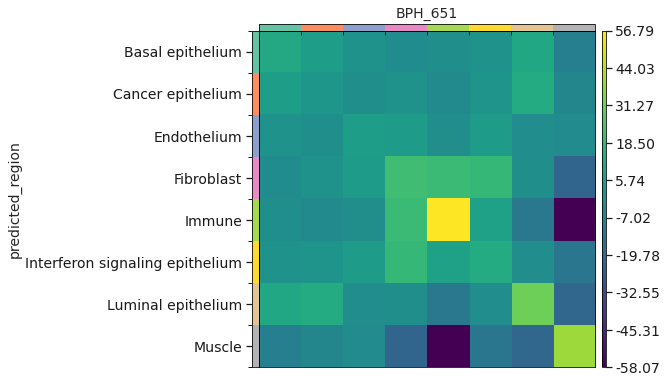

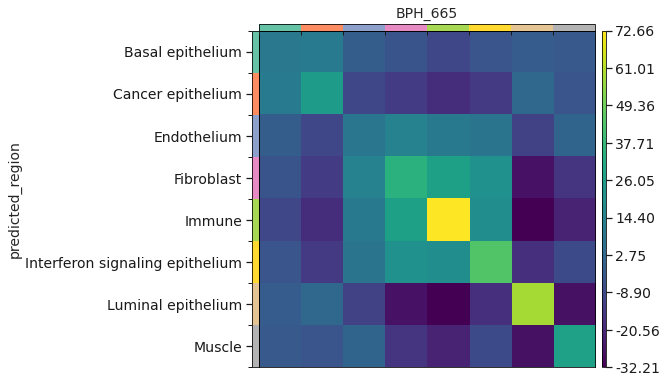

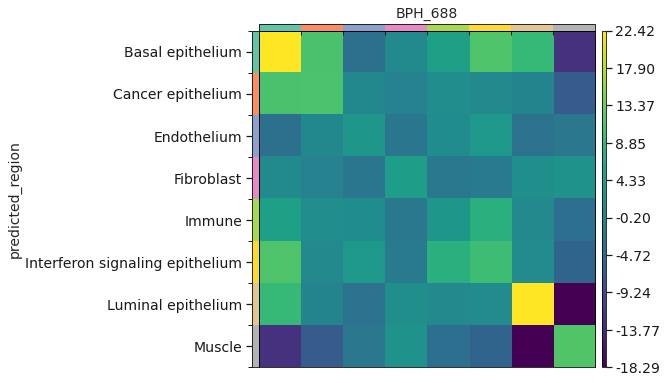

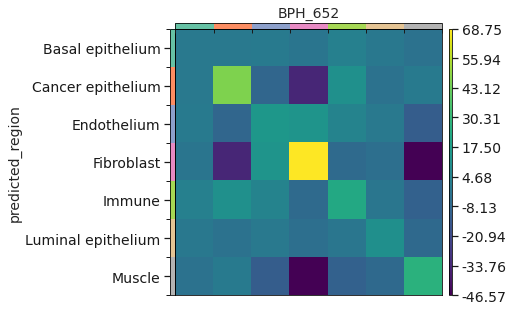

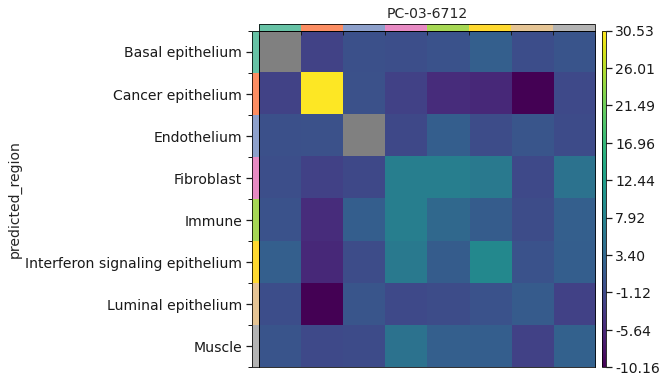

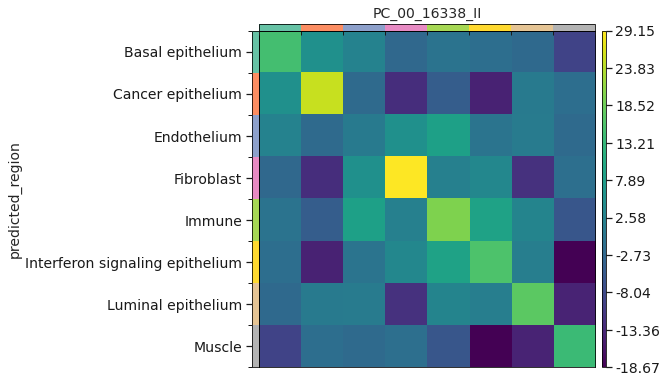

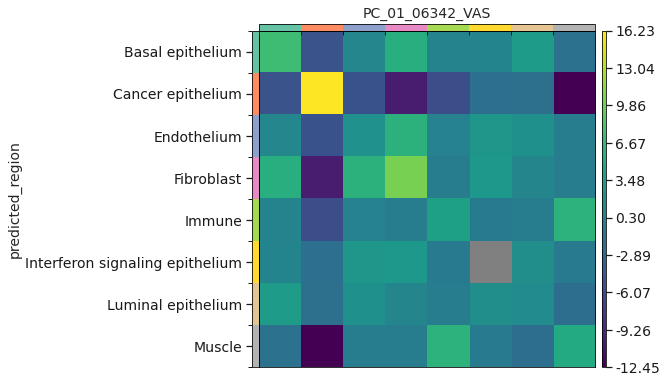

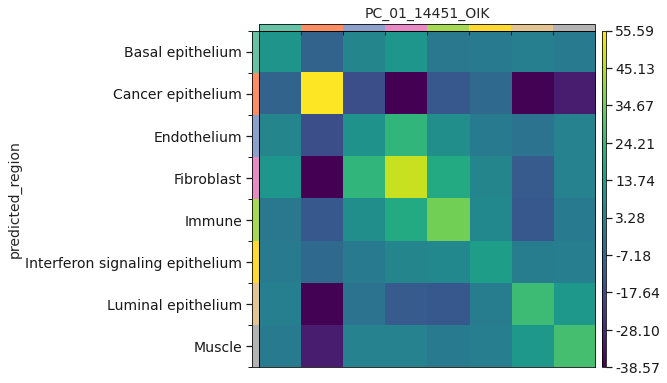

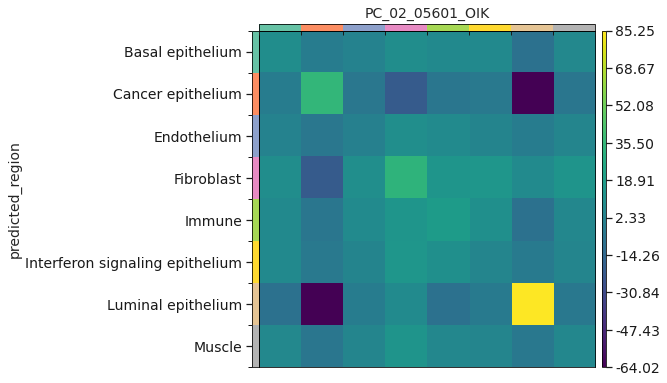

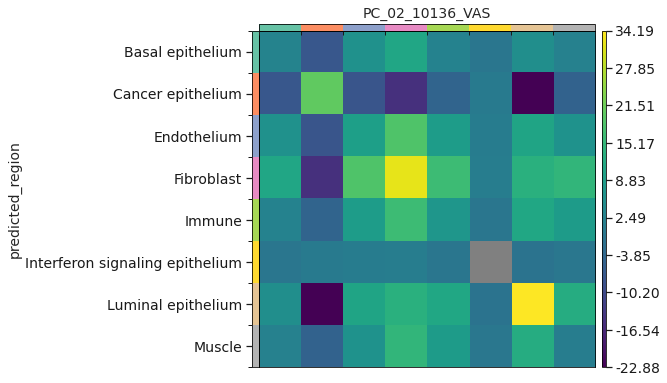

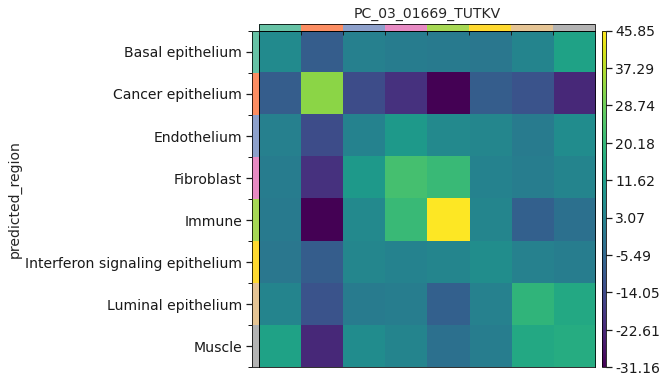

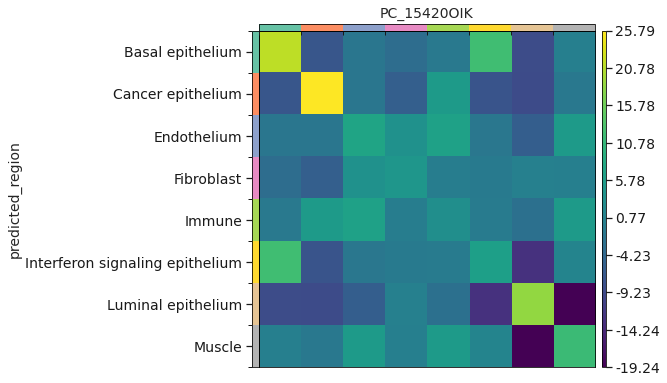

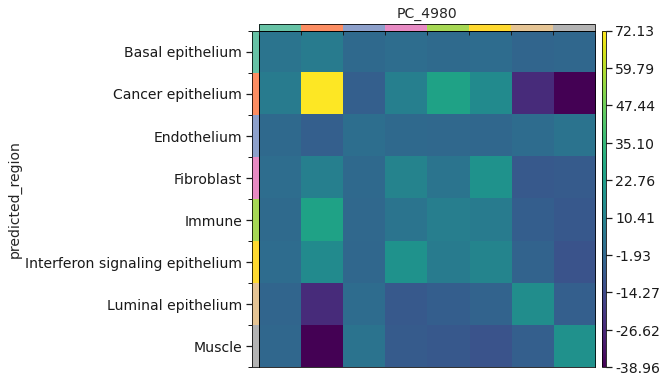

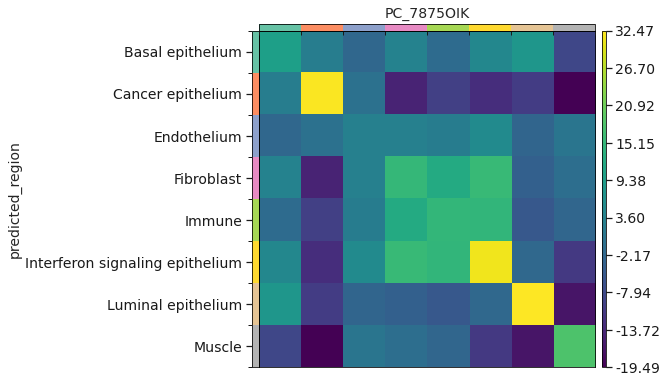

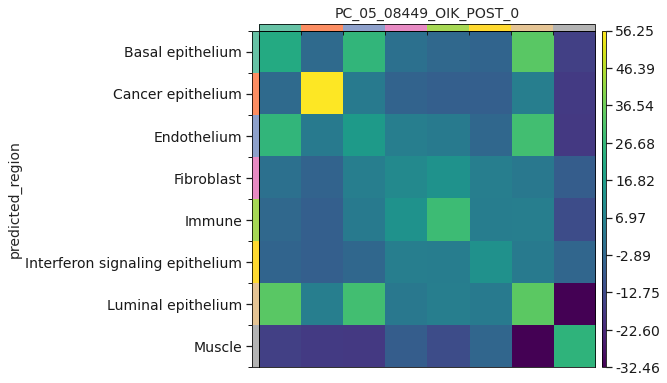

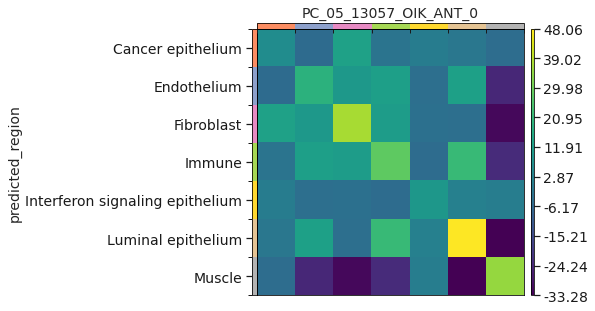

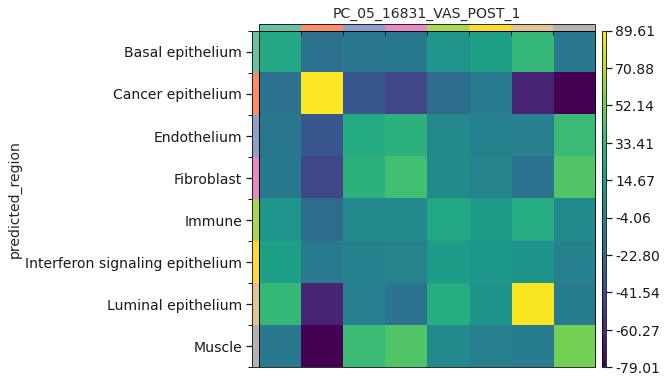

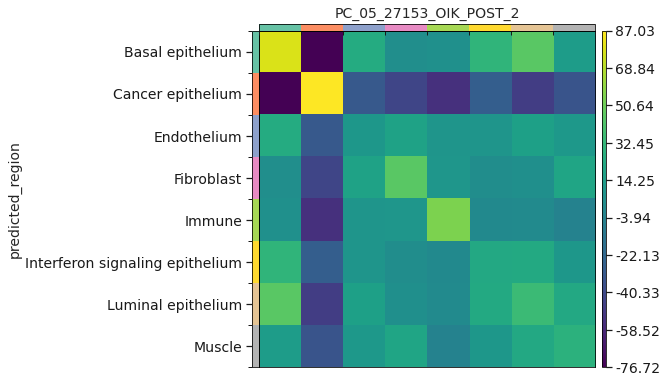

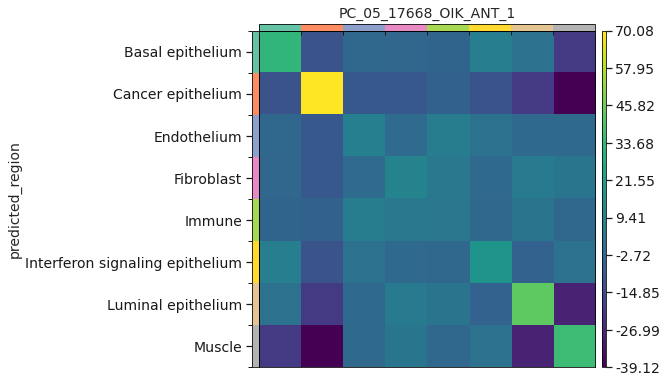

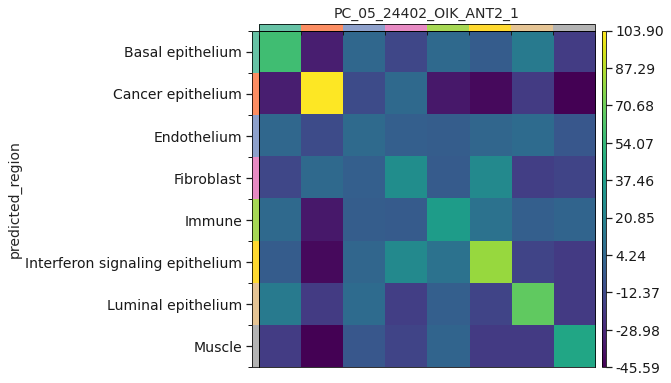

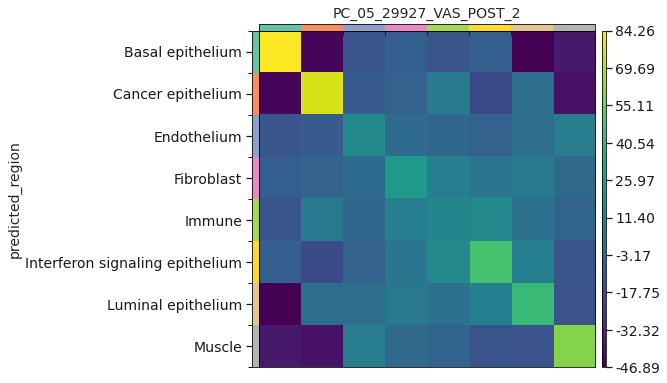

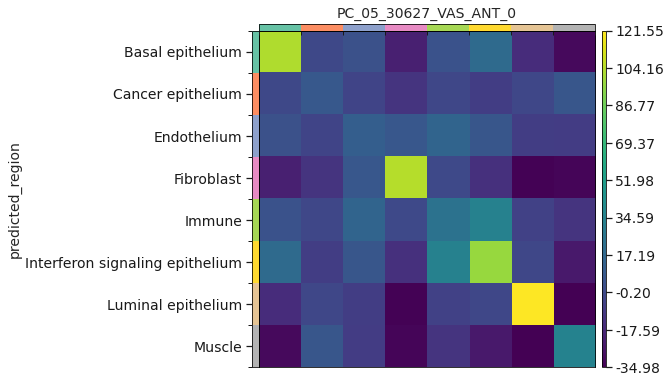

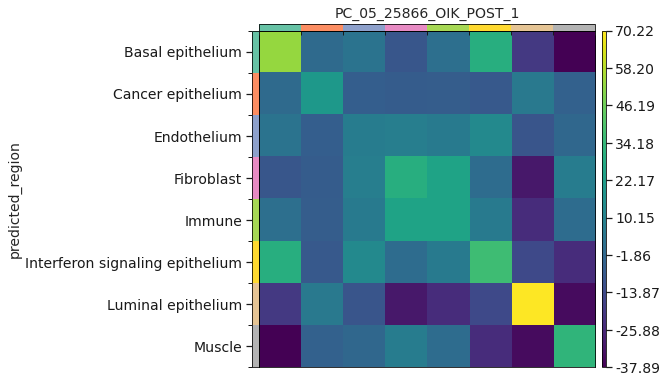

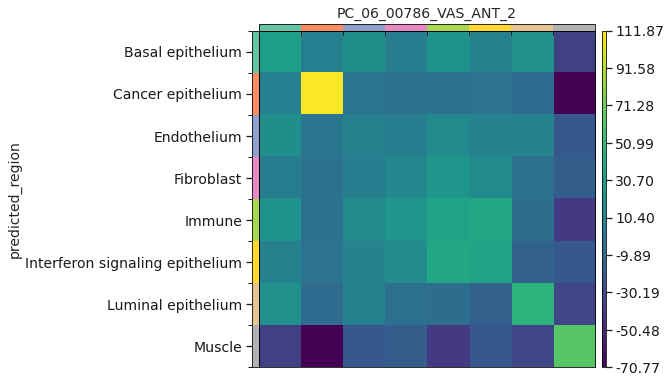

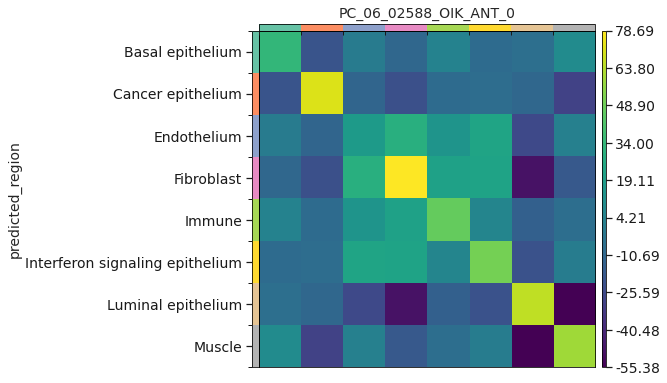

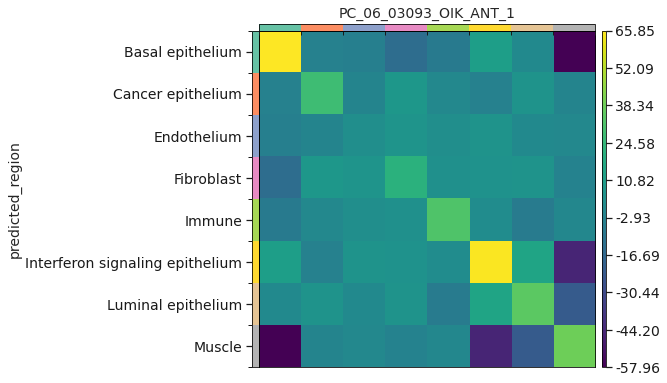

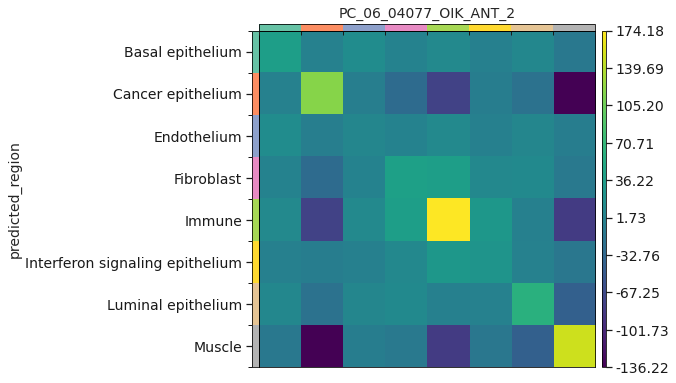

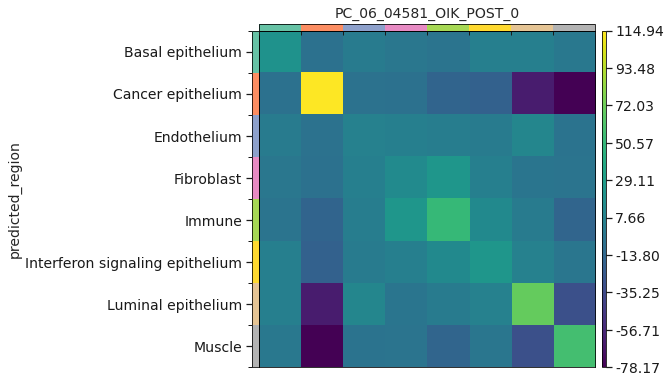

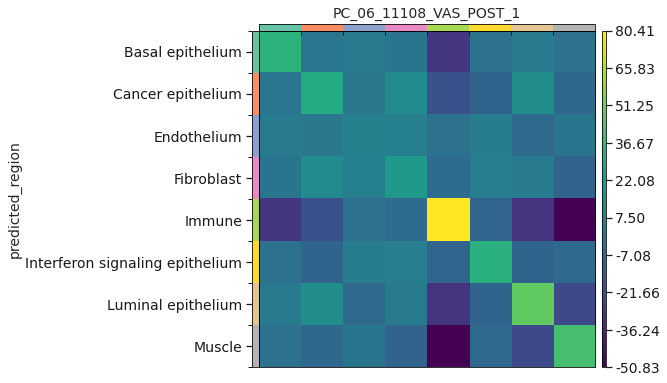

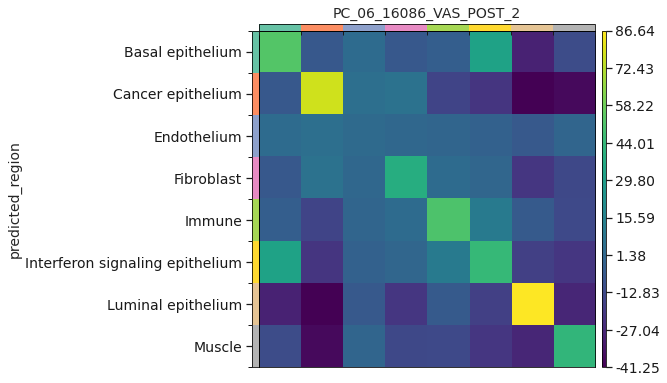

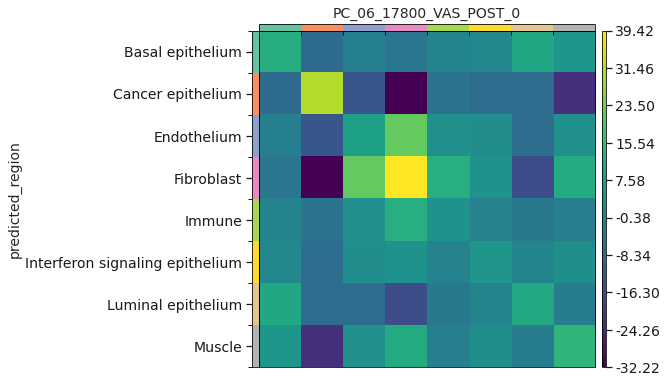

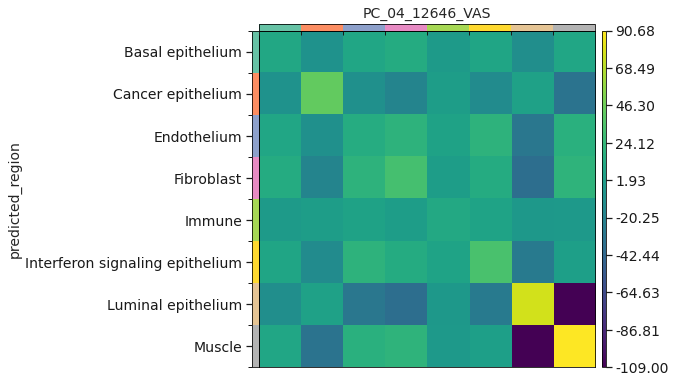

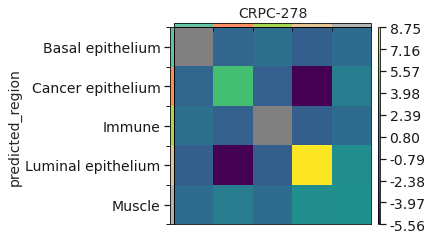

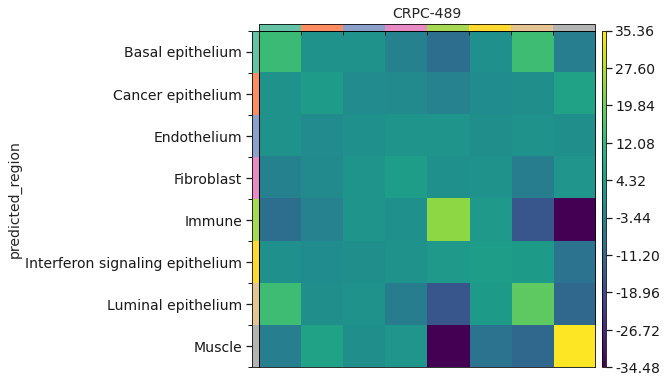

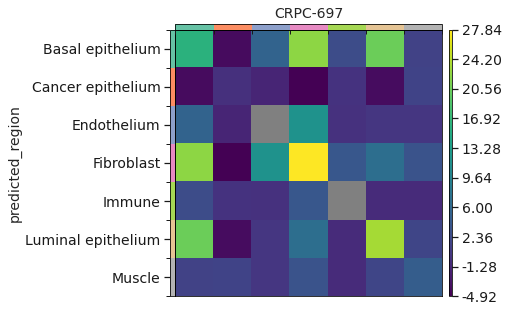

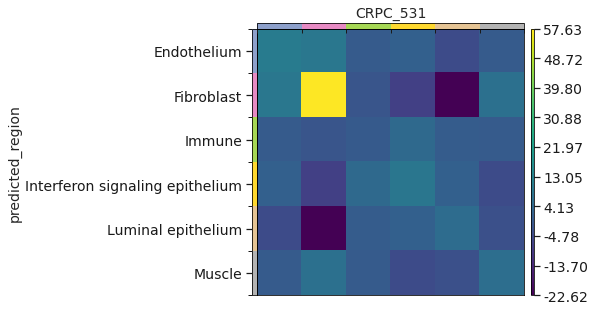

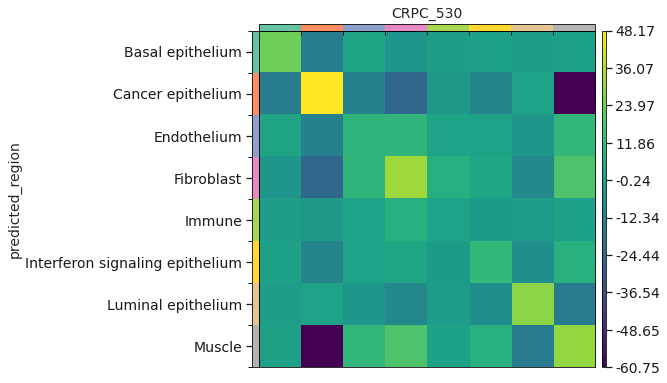

In [115]:
for sample in samples:
    slide = adata_slides[sample].copy()
    sq.gr.nhood_enrichment(slide, cluster_key='predicted_region',show_progress_bar=False)
    sq.pl.nhood_enrichment(slide,cluster_key='predicted_region',cmap='viridis',title=sample)

In [112]:
summary_mat = np.zeros((len(sorted_region_names),len(sorted_region_names)))
for sample in samples:
    slide = adata_slides[sample].copy()    
    sq.gr.nhood_enrichment(slide, cluster_key='predicted_region',show_progress_bar=False)

    mat = slide.uns['predicted_region_nhood_enrichment']['zscore'].copy()
    mat = np.nan_to_num(mat)


    missing = [c for c in sorted_region_names if c not in list(slide.obs['predicted_region'].cat.categories)]

    for missing_type in missing:

        insert_idx = list(sorted_region_names).index(missing_type)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[1]),axis = 0)
        mat = np.insert(mat, insert_idx, np.repeat(0,mat.shape[0]),axis = 1)

    summary_mat += mat


df = pd.DataFrame(summary_mat,index=sorted_region_names,columns=sorted_region_names)
sns.heatmap(df,cmap='viridis')